# Решение задачи "Классификация мест залежей нефти и газа"

Набор данных содержит 442 о различных нефтегазовых месторождениях.
Тренировочный набор - 309 строк.
Тестовый набор - 133 строк.

Каждое месторождение обладает 19 параметрами:
1. Field name - название месторождения
2. Reservoir unit - юнит месторождения
3. Country - страна расположения
4. Region - регион расположения
5. Basin name - название бассейна пород
6. Tectonic regime - тектонический режим
7. Latitude - широта
8. Longitude - долгота
9. Operator company - название компании
10. Onshore or oﬀshore - на суше или нет
11. Hydrocarbon type (main) - тип углеводорода
12. Reservoir status (current) - статус месторождения
13. Structural setting - структурные свойства
14. Depth (top reservoir ft TVD) - глубина
15. Reservoir period - литологический период
16. Lithology (main) - литология
17. Thickness (gross average ft) - общая толщина
18. Thickness (net pay average ft) - эффективная толщина
19. Porosity (matrix average 20) - пористость
20. Permeability (air average mD) – проницаемость

# Установка и импорт библиотек

In [4]:
!pip install folium geopandas shapely --quiet
!pip install numpy pandas seaborn matplotlib --quiet
!pip install scikit-learn imbalanced-learn --quiet

In [5]:
# иморитирование всех необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
import folium
import math
import geopandas as gpd
from shapely.geometry import Point
import requests
import zipfile
import os
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Считывание данных

In [7]:
# Считываем тренировочные данные
train = pd.read_csv("../data/oil/train_oil.csv")
test = pd.read_csv("../data/oil/oil_test.csv")

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (309, 20)
Test dataset shape: (133, 19)


# Исследование и обработка данных

## Первичный анализ

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [11]:
train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


### Визуализация пропусков

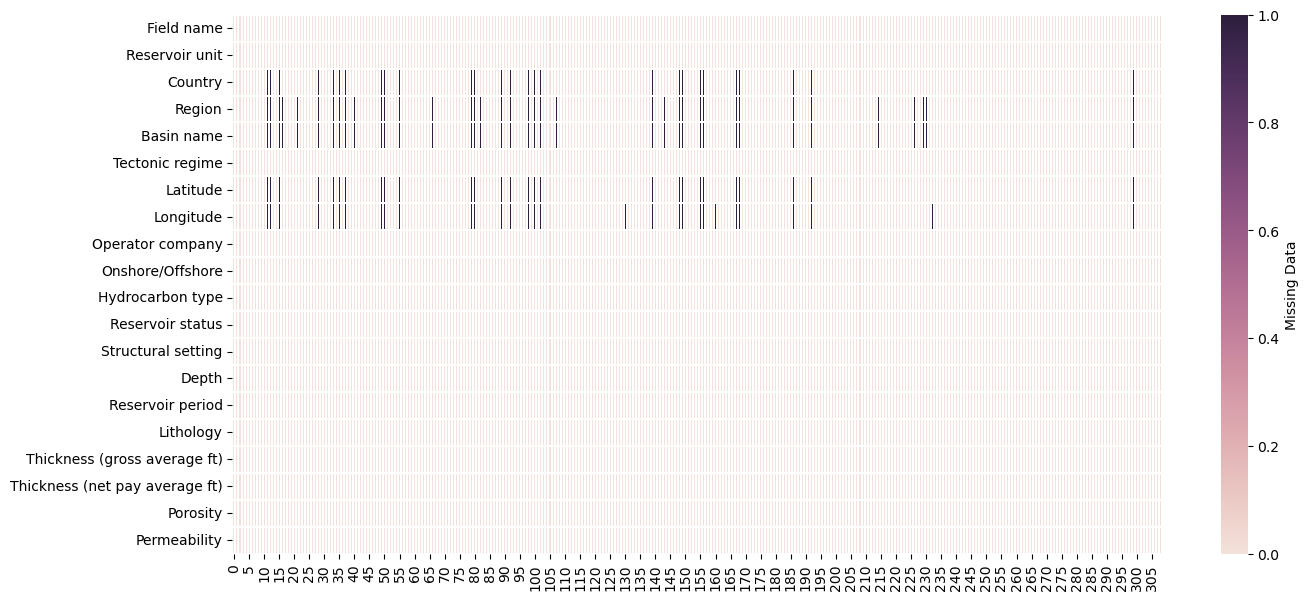

In [13]:
plt.figure(figsize=(15,7))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(train.isna().transpose(), cmap=cmap,
            cbar_kws={'label': 'Missing Data'}, linewidths=0.05);

Вообще логика такая - заполненные столбцы у меня и так модель обработает, а вот над пропусками, только человек может помочь, поэтому начинаю анализ с них:

1) Есть пропуск в геокоординатах(странно, мы чего не знаем где ресурс качаем? наверное можно из открытых источников восстановить вручную при желании, вряд ли у нас по миру настолько много нефти, что не получится мартышкином трудом за пару вечеров заполнить координаты). Но прежде чем эту рутину выполнять, проверим, насколько полезны гео-координаты в определении целевого признака.
2) Есть пропуски в странах, регионах и названии бассейна пород. Я конечно РГУ нефти и газа (НИУ) имени И.М. Губкина не заканчивал, но предположу, что бассейн можно коррелировать с таргетом. Страна и регион косвенно тоже может, если это маленькая страна у них может быть только один тип нефтегазового месторождения, проверю эту гипотезу.

## Исследование по гео-координатам

Наша задача классифицировать место залежи нефтегазового месторождения. Будет полезно визуализировать на карте известные источники. Выделим синим цветом морские, зеленым сушу и фиолетовым места которые одновременно и суша и море. Прочертим красными линиям меридианы и параллели для тех точек, у которых известна только одна координата.

P.S. Исследование не привело к профиту, поэтому не стал рефакторить этот код.

In [17]:
def is_finite_float(value):
    # Проверяем, является ли значение числом с плавающей точкой
    if isinstance(value, float) and not math.isnan(value):
        return True
    return False
    
map = folium.Map(location=[0, 0], zoom_start=2)
for row in train.itertuples(index=True, name='Pandas'):
    # todo: найти более надежный способ обратиться к колонке Onshore/Offshore
    onshore_offshore = row._10
    if is_finite_float(row.Latitude) and not is_finite_float(row.Longitude):
        folium.PolyLine(
            locations=[(row.Latitude, -180), (row.Latitude, 180)],  
            color='red',
            weight=2
        ).add_to(map)
    elif is_finite_float(row.Longitude) and not is_finite_float(row.Latitude):
        folium.PolyLine(
            locations=[(-90, row.Longitude), (90, row.Longitude)],
            color='red',
            weight=2
        ).add_to(map)
    elif is_finite_float(row.Longitude) and is_finite_float(row.Latitude):
        color = 'blue'
        if onshore_offshore == 'ONSHORE':
            color = 'green'
        elif onshore_offshore == 'ONSHORE-OFFSHORE':
            color = 'purple'
        folium.Marker([row.Latitude, row.Longitude], icon=folium.Icon(color=color)).add_to(map)
        
map

1) Однозначно можно отнести к морю, те точки, которые не на море. Фиолетовые точки не ясно по какой логике находятся на суше, а потому их с зелеными чисто географически разделить не получится. Но можно сказать что если точка на суше, то она точно не морская(уже хлеб). Наверное можно копнуть глубже, чтобы выжать из географии больше, но я удовлетворюсь этими знаниями.
2) а вот по красным линиям не вижу как делать хоть какие-то выводы

Проверим на тренировочном наборе определение моря по координатам:

In [19]:
# URL для скачивания данных Natural Earth (страны)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
# Путь для сохранения загруженного архива
zip_path = "world_map.zip"
# Путь для распаковки архива
extract_path = "natural_earth_data"

# Скачиваем данные
if not os.path.exists(zip_path):
    response = requests.get(url)
    with open(zip_path, "wb") as file:
        file.write(response.content)
# Распаковываем данные
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

shapefile_path = os.path.join(extract_path, 'ne_110m_admin_0_countries.shp')
# Загрузка набора данных Natural Earth (границы суши)
world = gpd.read_file(shapefile_path)

In [20]:
def is_on_land(latitude, longitude):
    # Создаем точку из координат
    point = Point(longitude, latitude)
    # Проверяем, находится ли точка в какой-либо из полигонов суши
    for _, country in world.iterrows():
        if country['geometry'].contains(point):
            return True
    return False

right_counts = 0
for row in train.itertuples(index=True, name='Pandas'):
    # todo: найти более надежный способ обратиться к колонке Onshore/Offshore
    onshore_offshore = row._10
    if is_on_land(row.Latitude, row.Longitude):
        if onshore_offshore != 'OFFSHORE':
            right_counts += 1
    else:
        if onshore_offshore == 'OFFSHORE':
            right_counts += 1
print(f'Процент правильного определения OFFSHORE по координатам: {round(right_counts / train.shape[0] * 100, 2)}%')

Процент правильного определения OFFSHORE по координатам: 89.97%


**Что-то грустное качество определения, я надеялся на 100%, имеет смысл использовать только если качество определения OFFSHORE из модели получу ниже 90%.**

## Исследование по странам/регионам

Проверяем гипотезу, что если страна маленькая у неё только один тип месторождения, а значит можно пронозировать в маленьких странах таргет исходя из тренировочных данных.

In [24]:
country_dict = {
    'EQUATORIAL GUINEA': 'Eq. Guinea',
    'NORWAY /UK': 'Norway',
    'UK /NORWAY': 'Norway',
    'PAPUA NEW GUINEA': 'Papua New Guinea',
    'SAUDI ARABIA': 'Saudi Arabia',
    'SOUTH AFRICA': 'South Africa',
    'TRINIDAD AND TOBAGO': 'Trinidad and Tobago',
    'TUNISIA /ALGERI': 'Algeria',
    'UAE': 'United Arab Emirates',
    'UK': 'United Kingdom',
    'USA': 'United States of America',
}

def get_country_area(country_name):
    if country_name in country_dict:
        country_name = country_dict.get(country_name)
    else:    
        country_name = country_name.capitalize()

    country = world[world['SOVEREIGNT'] == country_name]
    
    if not country.empty:
        country = country.to_crs(epsg=6933)  # Используем проекцию равновеликой цилиндрической проекции
        return country.iloc[0]['geometry'].area / 10**6
    else:
        return None

def should_delete(row):
    area = get_country_area(row.Country)
    # UZBEKISTAN 461 285 км2
    if area is not None:
        return area > 500_000
    else:
        return True    

filtered_df = train.dropna(subset=['Country', 'Region'])
mask = filtered_df.apply(should_delete, axis=1)
filtered_df = filtered_df[~mask]
unique_values = filtered_df.groupby(['Country', 'Region'])['Onshore/Offshore'].apply(lambda x: x.unique())

print(unique_values)

Country              Region             
FRANCE               EUROPE                           [ONSHORE, ONSHORE-OFFSHORE]
GABON                AFRICA                                            [OFFSHORE]
IRAQ                 MIDDLE EAST                                        [ONSHORE]
MALAYSIA             FAR EAST                                          [OFFSHORE]
NORWAY               EUROPE                                            [OFFSHORE]
NORWAY /UK           EUROPE                                            [OFFSHORE]
OMAN                 MIDDLE EAST                                        [ONSHORE]
PAPUA NEW GUINEA     FAR EAST                                           [ONSHORE]
QATAR                MIDDLE EAST                              [ONSHORE, OFFSHORE]
TRINIDAD AND TOBAGO  LATIN AMERICA                                      [ONSHORE]
TUNISIA              AFRICA                                            [OFFSHORE]
TURKMENISTAN         FORMER SOVIET UNION    [ONSHORE, OFF

**Гипотеза с треском провалилась**. По величине страны нельзя делать вывод о единственном месторождении. Единственное, что полезно, заметил что одна и та же страна в данных называется по-разному "NORWAY /UK" "UK /NORWAY". Но похоже что мне это не пригодится. Упражнения на гео-данных закончил.

## Исследование признака названия бассейна пород

In [27]:
filtered_df = train.dropna(subset=['Basin name'])
unique_counts = filtered_df.groupby('Basin name')['Onshore/Offshore'].nunique()
# Подсчет количества 'Basin name' с только одним уникальным значением
single_unique_count = (unique_counts == 1).sum()
# Общее количество уникальных 'Basin name'
total_basins = unique_counts.count()
percentage_single_unique = (single_unique_count / total_basins) * 100
print(f"Процент 'Basin name' с одним уникальным значением 'Onshore/Offshore': {percentage_single_unique:.2f}%")

unique_categories = filtered_df['Basin name'].unique()
print(f"Уникальные значения в столбце 'Basin name': {round(len(unique_categories) / filtered_df.shape[0] * 100, 2)}%")

Процент 'Basin name' с одним уникальным значением 'Onshore/Offshore': 94.62%
Уникальные значения в столбце 'Basin name': 34.32%


**Успех!** Название бассейна пород на 94% содержит только один тип месторождения. В тоже время поле относительно неуникально: только 34% разных бассейнов в тренировочных данных, то есть можно взять на карандаш использование имени бассейна для предсказания типа месторождения. Еще было бы круто закомбинировать это с выводами о геокоординатах. То есть если гео+имя бассейна скажут что это морской тип, можно поверить.

## Исследование признака глубины

In [30]:
selected_columns = train[['Depth', 'Onshore/Offshore']]
sorted_selected_columns = selected_columns.sort_values(by='Depth')

# Определяем диапазоны
bins = [0, 3000, 6000, 9000, 12000, 15000, 20000]
labels = ['0-3000', '3000-6000', '6000-9000', '9000-12000', '12000-15000', '15000-20000']
# Создаем новую колонку с диапазонами
sorted_selected_columns['DepthRange'] = pd.cut(sorted_selected_columns['Depth'], bins=bins, labels=labels, right=False)

# Группируем по диапазонам и объединяем уникальные значения в списки
grouped = sorted_selected_columns.groupby('DepthRange', observed=True)['Onshore/Offshore'].agg(
    UniqueValues=lambda x: list(set(x)),
    Count='size'
)

grouped

,UniqueValues,Count
DepthRange,,
0-3000,"[ONSHORE-OFFSHORE, ONSHORE, OFFSHORE]",46
3000-6000,"[ONSHORE-OFFSHORE, ONSHORE, OFFSHORE]",99
6000-9000,"[ONSHORE-OFFSHORE, ONSHORE, OFFSHORE]",83
9000-12000,"[ONSHORE, OFFSHORE]",55
12000-15000,"[ONSHORE, OFFSHORE]",21
15000-20000,[ONSHORE],5


Чтож, по глубине тоже не получится сделать вывод.

## Удаление неинформативных признаков(применяем к test)

In [33]:
# Функция для вычисления процента уникальности значений в столбце
def calculate_uniqueness_percentage(series):
    unique_count = series.nunique()  # Количество уникальных значений
    total_count = len(series)  # Общее количество значений
    uniqueness_percentage = (unique_count / total_count) * 100
    return uniqueness_percentage

# Применяем функцию к каждому столбцу и выводим результат
for column in train.columns:
    if column in ['Latitude', 'Longitude', 'Country', 'Region', 'Basin name', 'Onshore/Offshore']:
        continue
    uniqueness_percentage = calculate_uniqueness_percentage(train[column])
    print(f"{column} [{train[column].dtype}] = {uniqueness_percentage:.2f}%")

Field name [object] = 92.23%
Reservoir unit [object] = 83.50%
Tectonic regime [object] = 17.80%
Operator company [object] = 44.66%
Hydrocarbon type [object] = 1.29%
Reservoir status [object] = 4.21%
Structural setting [object] = 13.92%
Depth [int64] = 90.29%
Reservoir period [object] = 7.12%
Lithology [object] = 4.21%
Thickness (gross average ft) [float64] = 53.72%
Thickness (net pay average ft) [float64] = 53.72%
Porosity [float64] = 22.01%
Permeability [float64] = 48.87%


Уникальные строковые признаки не помогут в построении модели - их лучше удалить, чтобы не создавался шум. Также можно удалить неинформативные признаки 'Country', 'Region', которые были проанализированы выше.

In [35]:
columns_to_delete = ['Field name', 'Reservoir unit', 'Country', 'Region']
train.drop(columns=columns_to_delete, inplace=True)
test.drop(columns=columns_to_delete, inplace=True)

## Заполнение пропусков(применяем к test)

In [37]:
missing_count = train.isna().sum()
missing_percentage = (missing_count / len(train)) * 100
missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': round(missing_percentage, 2)
})

missing_data[missing_data['Missing Count'] > 0]

,Missing Count,Missing Percentage
Basin name,38,12.30
Latitude,27,8.74
Longitude,30,9.71


* Гео-координаты: из них 27 отсутсвует и широта и долгота и 3 записи только latitude(широта) - это видно по построенной карте. Причем с точностью 90% по координатам можно отнести месторождение к воде или не воде, поэтому удалять не будем, но и заполнить автоматически никак не получится(если раскопать данные из открытых источников, то в них скорее всего сразу будет и таргет, что сломает имитацию эксперемента).
* Имя бассейна тоже уже анализировали, он достаточно уникален(34%) и ему на 94% однозначно соответвует таргет, поэтому его не удаляем, но и заполнить не получится.

Итого, пропуски в строках этих колонок не заполнить, можно только удалить, но не будем спешить это делать.

Для будущей балансировки методом SMOTE потребуется избавиться от NaN значений. Данных мало и мы жадные, удалять строки не станем, заполним пропуски с помощью SimpleImputer.

In [40]:
basin_name_imputer = SimpleImputer(strategy='most_frequent')
train['Basin name'] = basin_name_imputer.fit_transform(train[['Basin name']]).ravel()
test['Basin name'] = basin_name_imputer.transform(test[['Basin name']]).ravel()

train['Latitude'] = train['Latitude'].fillna(0)
train['Longitude'] = train['Longitude'].fillna(0)
test['Latitude'] = test['Latitude'].fillna(0)
test['Longitude'] = test['Longitude'].fillna(0)

## Обработка категориальных признаков(применяем к test)

Каждое месторождение обладает 19 параметрами:

6. Tectonic regime - тектонический режим
9. Operator company - название компании
11. Hydrocarbon type (main) - тип углеводорода
12. Reservoir status (current) - статус месторождения
13. Structural setting - структурные свойства
15. Reservoir period - литологический период
16. Lithology (main) - литология
10. Onshore or oﬀshore - на суше или нет

In [43]:
category_columns = ['Basin name', 'Tectonic regime', 'Operator company', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Reservoir period', 'Lithology', 'Onshore/Offshore']
train[category_columns].head()

,Basin name,Tectonic regime,Operator company,Hydrocarbon type,Reservoir status,Structural setting,Reservoir period,Lithology,Onshore/Offshore
0,VOLGA-URAL,COMPRESSION/EVAPORITE,NIZHNEVOLZHSKNET,OIL,DECLINING PRODUCTION,FORELAND,CARBONIFEROUS,SANDSTONE,ONSHORE
1,ESPIRITO SANTO,EXTENSION,PETROBRAS,OIL,NEARLY DEPLETED,PASSIVE MARGIN,PALEOGENE,SANDSTONE,ONSHORE
2,THE GULF,COMPRESSION/EVAPORITE,SAUDI ARAMCO,OIL,REJUVENATING,FORELAND,JURASSIC,LIMESTONE,ONSHORE
3,NORTH SEA NORTHERN,EXTENSION,CNR,OIL,NEARLY DEPLETED,RIFT,JURASSIC,SANDSTONE,OFFSHORE
4,WESTERN CANADA,COMPRESSION,NUMEROUS,OIL,UNKNOWN,FORELAND,DEVONIAN,DOLOMITE,ONSHORE


In [44]:
train['Basin name'].value_counts()

Basin name
WESTERN CANADA                     62
GULF OF MEXICO NORTHERN ONSHORE    19
NORTH SEA CENTRAL                  14
NORTH SEA NORTHERN                 12
PERMIAN                            10
                                   ..
SIERRA GRANDE UPLIFT                1
FORT WORTH                          1
OTWAY                               1
UINTA/PICEANCE                      1
UINTA                               1
Name: count, Length: 93, dtype: int64

In [45]:
train['Tectonic regime'].value_counts()

Tectonic regime
COMPRESSION                                                 72
COMPRESSION/EROSION                                         29
EXTENSION                                                   28
COMPRESSION/EVAPORITE                                       22
INVERSION/COMPRESSION/EXTENSION                             20
EXTENSION/EROSION                                           13
GRAVITY/EXTENSION/EVAPORITE                                 10
GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION                 8
INVERSION/COMPRESSION/EXTENSION/EROSION                      7
COMPRESSION/EVAPORITE/EXTENSION/LINKED                       7
INVERSION/STRIKE-SLIP/TRANSPRESSION/EXTENSION/BASEMENT-I     6
GRAVITY/EVAPORITE/COMPRESSION                                5
COMPRESSION/EXTENSION/LINKED                                 5
INVERSION/COMPRESSION/EXTENSION/EVAPORITE/GRAVITY            5
INVERSION/COMPRESSION/EXTENSION/EVAPORITE                    5
GRAVITY/EVAPORITE/EXTENSION            

In [46]:
train['Structural setting'].value_counts()

Structural setting
FORELAND                      78
RIFT                          46
INTRACRATONIC                 33
THRUST                        18
PASSIVE MARGIN                13
SALT/FORELAND                 13
SALT/PASSIVE MARGIN           10
INVERSION/RIFT                 9
INVERSION/BACKARC              8
DELTA/PASSIVE MARGIN           7
SALT/INVERSION/RIFT            6
DELTA/SALT/PASSIVE MARGIN      5
SUB-THRUST/FORELAND            4
RIFT/SALT                      4
THRUST/FORELAND                4
SUB-SALT/INVERSION             4
SUB-SALT/FORELAND              4
SUB-SALT/RIFT                  3
WRENCH                         3
RIFT/INVERSION                 3
SALT/RIFT                      3
BACKARC                        3
WRENCH/FORELAND                2
THRUST/SUB-THRUST/FORELAND     2
FORELAND/SALT                  2
WRENCH/DELTA                   2
SUB-THRUST                     2
FORELAND/THRUST                2
INVERSION/FORELAND             2
RIFT/PASSIVE MARGIN     

In [47]:
train['Operator company'].value_counts()

Operator company
NUMEROUS                        28
PETROCHINA                      17
CHEVRON                         16
BP                              12
SHELL                           10
                                ..
DRAGON OIL                       1
PETROTRIN                        1
GULF OIL                         1
WOODSIDE                         1
MATRIX PRODUCTION AND OTHERS     1
Name: count, Length: 138, dtype: int64

In [48]:
train['Hydrocarbon type'].value_counts()

Hydrocarbon type
OIL               231
GAS                46
GAS-CONDENSATE     30
CARBON DIOXIDE      2
Name: count, dtype: int64

In [49]:
train['Reservoir status'].value_counts()

Reservoir status
DECLINING PRODUCTION        88
MATURE PRODUCTION           63
NEARLY DEPLETED             55
PLATEAU PRODUCTION          30
DEVELOPING                  22
REJUVENATING                18
UNKNOWN                      9
UNDEVELOPED                  7
ABANDONED                    6
SECOND PLATEAU PRODUTION     6
CONTINUING DEVELOPMENT       3
TEMPORARILY SHUT-IN          1
DEPLETED                     1
Name: count, dtype: int64

In [50]:
train['Reservoir period'].value_counts()

Reservoir period
CRETACEOUS                78
JURASSIC                  41
NEOGENE                   39
PALEOGENE                 37
CARBONIFEROUS             29
PERMIAN                   28
DEVONIAN                  15
TRIASSIC                   8
CRETACEOUS-PALEOGENE       8
CARBONIFEROUS-PERMIAN      4
PROTEROZOIC                4
ORDOVICIAN                 3
PALEOGENE-NEOGENE          3
TRIASSIC-JURASSIC          2
JURASSIC-CRETACEOUS        2
CAMBRIAN-ORDOVICIAN        2
DEVONIAN-PERMIAN           1
CAMBRIAN                   1
DEVONIAN-CARBONIFEROUS     1
SILURIAN                   1
MESOZOIC                   1
PALEOZOIC                  1
Name: count, dtype: int64

In [51]:
train['Lithology'].value_counts()

Lithology
SANDSTONE                    184
DOLOMITE                      45
LIMESTONE                     38
SHALY SANDSTONE                6
THINLY-BEDDED SANDSTONE        6
CONGLOMERATE                   6
CHALK                          6
LOW-RESISTIVITY SANDSTONE      6
CHALKY LIMESTONE               5
DOLOMITIC LIMESTONE            3
SILTSTONE                      2
SHALE                          1
VOLCANICS                      1
Name: count, dtype: int64

In [52]:
train['Onshore/Offshore'].value_counts()

Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64

* Как мы видим в колонках 'Tectonic regime', 'Structural setting' множество разных категорий, причем одному объекту может соответствовать несколько категорий сразу. Поэтому используем MultiLabelBinarizer. Если в тестовом наборе данных встречается категория, которой не было в обучающем наборе, MultiLabelBinarizer не будет знать, как её обработать, поскольку он был обучен только на категориях, присутствующих в обучающем наборе. В таких случаях новая категория будет игнорироваться, и соответствующие бинарные столбцы будут заполнены нулями.
* А вот в колонках 'Basin name', 'Operator company', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology' одна категория, поэтому можно использовать кодировщик OrdinalEncoder
* Для таргета по той же причине'Onshore/Offshore' используем LabelEncoder

Примением MultiLabelBinarizer к 'Tectonic regime'

In [55]:
tectonic_regime_mlb = MultiLabelBinarizer()
train['Tectonic regime_split'] = train['Tectonic regime'].str.split('/')
train_tectonic_regime_encoded = tectonic_regime_mlb.fit_transform(train['Tectonic regime_split'])
prefix = 'Tectonic_regime_'
column_names = [prefix + cls for cls in tectonic_regime_mlb.classes_]
train_tectonic_regime_df = pd.DataFrame(train_tectonic_regime_encoded, columns=column_names)

test['Tectonic regime_split'] = test['Tectonic regime'].str.split('/')
test_tectonic_regime_encoded = tectonic_regime_mlb.transform(test['Tectonic regime_split'])
test_tectonic_regime_df = pd.DataFrame(test_tectonic_regime_encoded, columns=column_names)

Примением MultiLabelBinarizer к 'Structural setting'

In [57]:
structural_setting_mlb = MultiLabelBinarizer()
train['Structural setting_split'] = train['Structural setting'].str.split('/')
train_structural_setting_encoded = structural_setting_mlb.fit_transform(train['Structural setting_split'])
prefix = 'Structural_setting_'
column_names = [prefix + cls for cls in structural_setting_mlb.classes_]
train_structural_setting_df = pd.DataFrame(train_structural_setting_encoded, columns=column_names)

test['Structural setting_split'] = test['Structural setting'].str.split('/')
test_structural_setting_encoded = structural_setting_mlb.transform(test['Structural setting_split'])
test_structural_setting_df = pd.DataFrame(test_structural_setting_encoded, columns=column_names)

/Users/v.papadyk/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [58]:
train = pd.concat([train, train_tectonic_regime_df, train_structural_setting_df], axis=1)
test = pd.concat([test, test_tectonic_regime_df, test_structural_setting_df], axis=1)

columns_to_delete = ['Tectonic regime', 'Tectonic regime_split', 'Structural setting', 'Structural setting_split']
train.drop(columns=columns_to_delete, inplace=True)
test.drop(columns=columns_to_delete, inplace=True)

Применяем OrdinalEncoder к 'Basin name', 'Operator company', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology'

In [60]:
# Список категориальных столбцов
categ = ['Basin name', 'Operator company', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology']
# Создаем OrdinalEncoder, обрабатываем неизвестные категории специальным значением -1
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Обучаем на тренировочных данных и преобразуем сразу train и test
train_encoded = ordinal_encoder.fit_transform(train[categ])
test_encoded = ordinal_encoder.transform(test[categ])

# Заменяем старые категориальные столбцы новыми закодированными
train[categ] = train_encoded
test[categ] = test_encoded

Применяем LabelEncoder к Onshore/Offshore

In [62]:
label_encoder = LabelEncoder()
train['Onshore/Offshore'] = label_encoder.fit_transform(train['Onshore/Offshore'])

In [63]:
train.head()

,Basin name,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Depth,Reservoir period,Lithology,...,Structural_setting_FORELAND,Structural_setting_INTRACRATONIC,Structural_setting_INVERSION,Structural_setting_PASSIVE MARGIN,Structural_setting_RIFT,Structural_setting_SALT,Structural_setting_SUB-SALT,Structural_setting_SUB-THRUST,Structural_setting_THRUST,Structural_setting_WRENCH
0,86.0,51.0000,44.8042,75.0,1,3.0,2.0,1870,2.0,7.0,...,1,0,0,0,0,0,0,0,0,0
1,20.0,-19.6017,-39.8332,88.0,1,3.0,6.0,4843,14.0,7.0,...,0,0,0,1,0,0,0,0,0,0
2,81.0,26.0800,49.8100,104.0,1,3.0,8.0,6050,9.0,5.0,...,1,0,0,0,0,0,0,0,0,0
3,51.0,61.3833,1.7500,34.0,0,3.0,6.0,8988,9.0,7.0,...,0,0,0,0,1,0,0,0,0,0
4,88.0,53.2287,-115.8008,77.0,1,3.0,12.0,9306,6.0,3.0,...,1,0,0,0,0,0,0,0,0,0


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Basin name                         309 non-null    float64
 1   Latitude                           309 non-null    float64
 2   Longitude                          309 non-null    float64
 3   Operator company                   309 non-null    float64
 4   Onshore/Offshore                   309 non-null    int64  
 5   Hydrocarbon type                   309 non-null    float64
 6   Reservoir status                   309 non-null    float64
 7   Depth                              309 non-null    int64  
 8   Reservoir period                   309 non-null    float64
 9   Lithology                          309 non-null    float64
 10  Thickness (gross average ft)       309 non-null    float64
 11  Thickness (net pay average ft)     309 non-null    float64

## Проверка линейных зависимостей в данных(применяем к test)

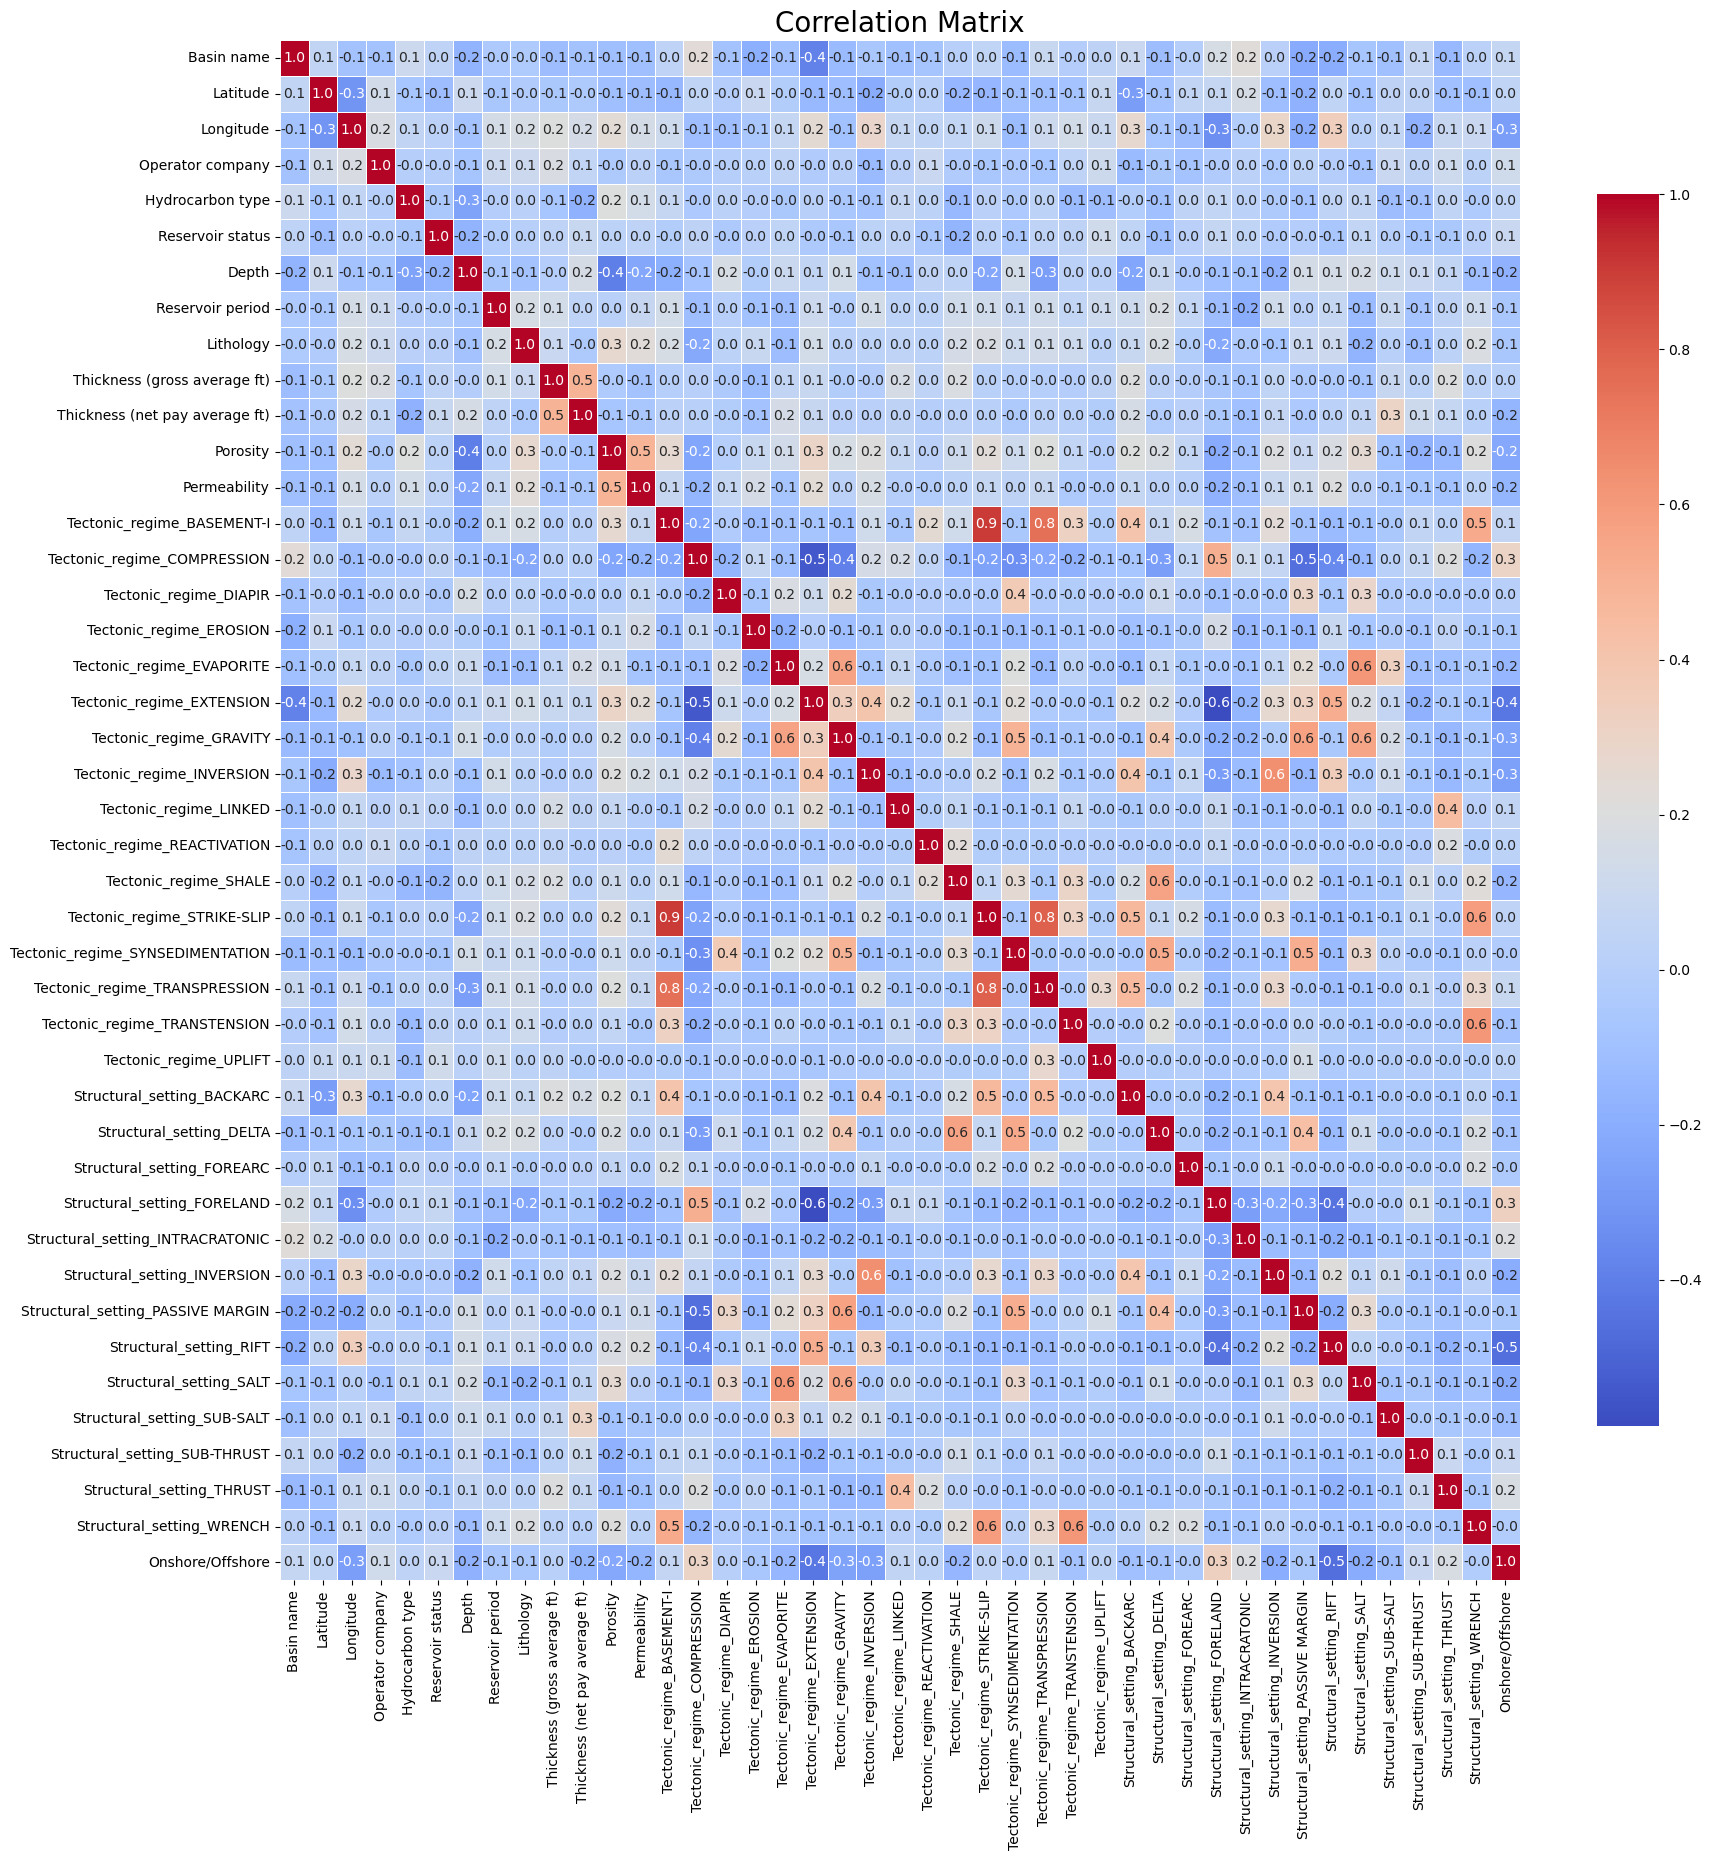

In [66]:
columns = [col for col in train.columns if col != 'Onshore/Offshore'] + ['Onshore/Offshore']
train = train[columns]

corr_matrix = train.corr()
# Настройка размера фигуры
plt.figure(figsize=(20, 20))
# Построение тепловой карты
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".1f", 
            linewidths=.5, cbar_kws={"shrink": .8})
# Настройка заголовка
plt.title('Correlation Matrix', size=20)
# Отображение графика
plt.show()

* Корреляция сообщает, как переменные в наборе данных связаны друг с другом. Есть пару флагов признака "тектонический режим", которые одновременно загораются(0.9 и 0.8). Можно удалить один из признаков, которые коррелирует на 0.9(тот который меньше на таргет коррелирует).
* На таргет сильнее всего влияет структурное свойство RIFT(-0.5). В целом вывод такой, что нет линейной зависимости между признаками и таргетом.

In [68]:
train.drop(columns=['Tectonic_regime_STRIKE-SLIP'], inplace=True)
test.drop(columns=['Tectonic_regime_STRIKE-SLIP'], inplace=True)

## Балансировка по целевому признаку

Посмотрим на баланс классов.

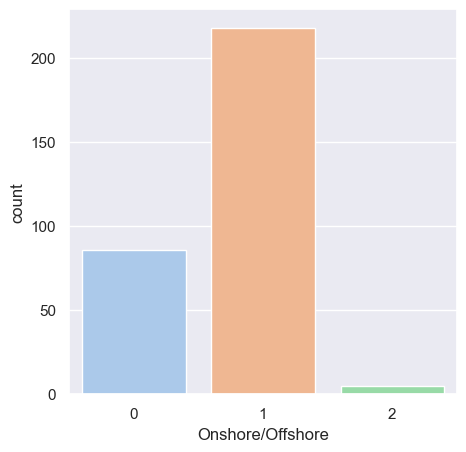

Onshore/Offshore
1    218
0     86
2      5
Name: count, dtype: int64

In [71]:
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(train['Onshore/Offshore'])
sns.countplot(x='Onshore/Offshore', data=y_data, hue='Onshore/Offshore', palette='pastel', legend=False)
plt.show()
train['Onshore/Offshore'].value_counts()

Поскольку данных очень мало будем балансировать по методу oversampling.

In [73]:
X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

smote = SMOTE(sampling_strategy='all', k_neighbors=3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

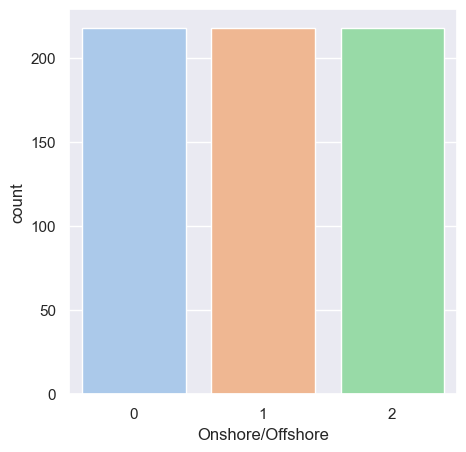

Onshore/Offshore
1    218
0    218
2    218
Name: count, dtype: int64

In [74]:
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(y_resampled)
sns.countplot(x='Onshore/Offshore', data=y_data, hue='Onshore/Offshore', palette='pastel', legend=False)
plt.show()
y_resampled.value_counts()

# Обучение модели

## Эксперементируем с выбором модели

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,           # 20% данных в тест
    random_state=42,         # Фиксируем для воспроизводимости
    stratify=y_resampled     # Стратифицированное разбиение
)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (523, 41), (523,)
Train dataset size: (131, 41), (131,)


In [78]:
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(2)
randomForest = RandomForestClassifier(n_estimators=100, random_state=42)
svm_poly = SVC(kernel='poly', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)
randomForest.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_randomForest = randomForest.predict(X_test)
y_pred_svm_poly = svm_poly.predict(X_test)
y_pred_svm_rbf = svm_rbf.predict(X_test)

In [79]:
print('decision tree\n', classification_report(y_test, y_pred_tree))
print('knn\n', classification_report(y_test, y_pred_knn))
print('random forest\n', classification_report(y_test, y_pred_randomForest))
print('svm poly\n', classification_report(y_test, y_pred_svm_poly))
print('svm rbf\n', classification_report(y_test, y_pred_svm_rbf))

decision tree
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        43
           1       0.83      0.80      0.81        44
           2       0.93      0.98      0.96        44

    accuracy                           0.88       131
   macro avg       0.88      0.88      0.88       131
weighted avg       0.88      0.88      0.88       131

knn
               precision    recall  f1-score   support

           0       0.69      0.98      0.81        43
           1       0.96      0.52      0.68        44
           2       0.91      0.95      0.93        44

    accuracy                           0.82       131
   macro avg       0.85      0.82      0.81       131
weighted avg       0.85      0.82      0.81       131

random forest
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.91      0.89      0.90        44
           2       0.98      0.91      0

У модели svc(с ядрами poly и rbf) крайне низкие показатели f1-score. Явный фаворит по метрикам модель случайного леса.

In [81]:
# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy decision tree: {accuracy_score(y_test, y_pred_tree):.3f}')
print(f'Accuracy knn: {accuracy_score(y_test, y_pred_knn):.3f}')
print(f'Accuracy random forest: {accuracy_score(y_test, y_pred_randomForest):.3f}')
print(f'Accuracy svm poly: {accuracy_score(y_test, y_pred_svm_poly):.3f}')
print(f'Accuracy svm rbf: {accuracy_score(y_test, y_pred_svm_rbf):.3f}')

Accuracy decision tree: 0.878
Accuracy knn: 0.817
Accuracy random forest: 0.924
Accuracy svm poly: 0.580
Accuracy svm rbf: 0.626


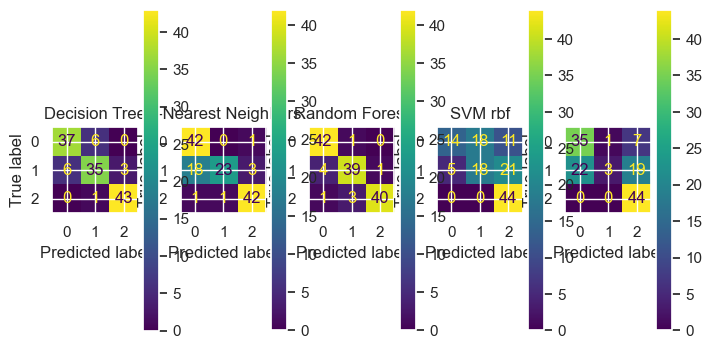

In [82]:
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
conf_matrix_randomForest = confusion_matrix(y_test, y_pred_randomForest)
conf_matrix_svm_poly = confusion_matrix(y_test, y_pred_svm_poly)
conf_matrix_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)

fig, axes = plt.subplots(1, 5, figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix_tree, display_labels=tree.classes_)
display.plot(ax=axes[0])
axes[0].set_title("Decision Tree")

display = ConfusionMatrixDisplay(conf_matrix_knn, display_labels=knn.classes_)
display.plot(ax=axes[1]);
axes[1].set_title("K-Nearest Neighbors")

display = ConfusionMatrixDisplay(conf_matrix_randomForest, display_labels=randomForest.classes_)
display.plot(ax=axes[2]);
axes[2].set_title("Random Forest")

display = ConfusionMatrixDisplay(conf_matrix_svm_poly, display_labels=svm_poly.classes_)
display.plot(ax=axes[3]);
axes[3].set_title("SVM poly")

display = ConfusionMatrixDisplay(conf_matrix_svm_rbf, display_labels=svm_rbf.classes_)
display.plot(ax=axes[4]);
axes[3].set_title("SVM rbf")

plt.show()

Наилучшие результаты показывает модель Random forest. Попробуем подобрать наилучшие гиперпараметры.

## Подбор гиперпараметров модели RandomForest

### Использование GridSearchCV

In [86]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 5],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score (micro): {f1:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
F1 Score (micro): 0.916

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91        43
           1       0.90      0.84      0.87        44
           2       1.00      0.93      0.96        44

    accuracy                           0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131



**Лучшие параметры**: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
F1 Score (micro): 0.916

### Использование RandomizedSearchCV

In [89]:
param_dist = {
    'n_estimators': randint(50, 900),
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=1000, cv=5, scoring='f1_micro', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
y_pred = random_search.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score (micro): {f1:.3f}")

# Подробный отчет о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'bootstrap': False, 'max_depth': 55, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 373}
F1 Score (micro): 0.916

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        43
           1       0.89      0.89      0.89        44
           2       1.00      0.91      0.95        44

    accuracy                           0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131



**Лучшие параметры**: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 63}
F1 Score (micro): 0.924

Пояснения:
Выбрана модель RandomForest. Подбор гиперпараметров был по метрике f1 micro.
f1 -  гармоническое среднее между точностью и полнотой. micro - вычисляет метрику глобально, считая общее количество истинно положительных, ложноположительных и ложноотрицательных предсказаний.

Полученные параметры:
Использовался весь датасет для обучения каждого дерева. Их получилось 63 штуки. Максимальная глубина деревьев решения - 30. Минимальное количество объектов, необходимое для листового узла - 1; минимальное объектов образцов, необходимое для разделения внутреннего узла - 3.

## Обучим лучшую модель на всей обучающей выборке

In [92]:
print(X_train.shape, y_train.shape)
print(X_resampled.shape, y_resampled.shape)

(523, 41) (523,)
(654, 41) (654,)


In [93]:
randomForestBest = RandomForestClassifier(n_estimators=63, max_depth=30, bootstrap=False, min_samples_leaf=1, min_samples_split=3, random_state=42)
randomForestBest.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=3,
                       n_estimators=63, random_state=42)

## Публикация результата

In [95]:
y_test_pred_best = randomForestBest.predict(test)

ans_df = pd.DataFrame(y_test_pred_best, columns=['Onshore/Offshore '])
ans_df.reset_index(inplace=True)
ans_df.to_csv('oil-submition.csv', index=False)

**Итоговый score**: 0.91571

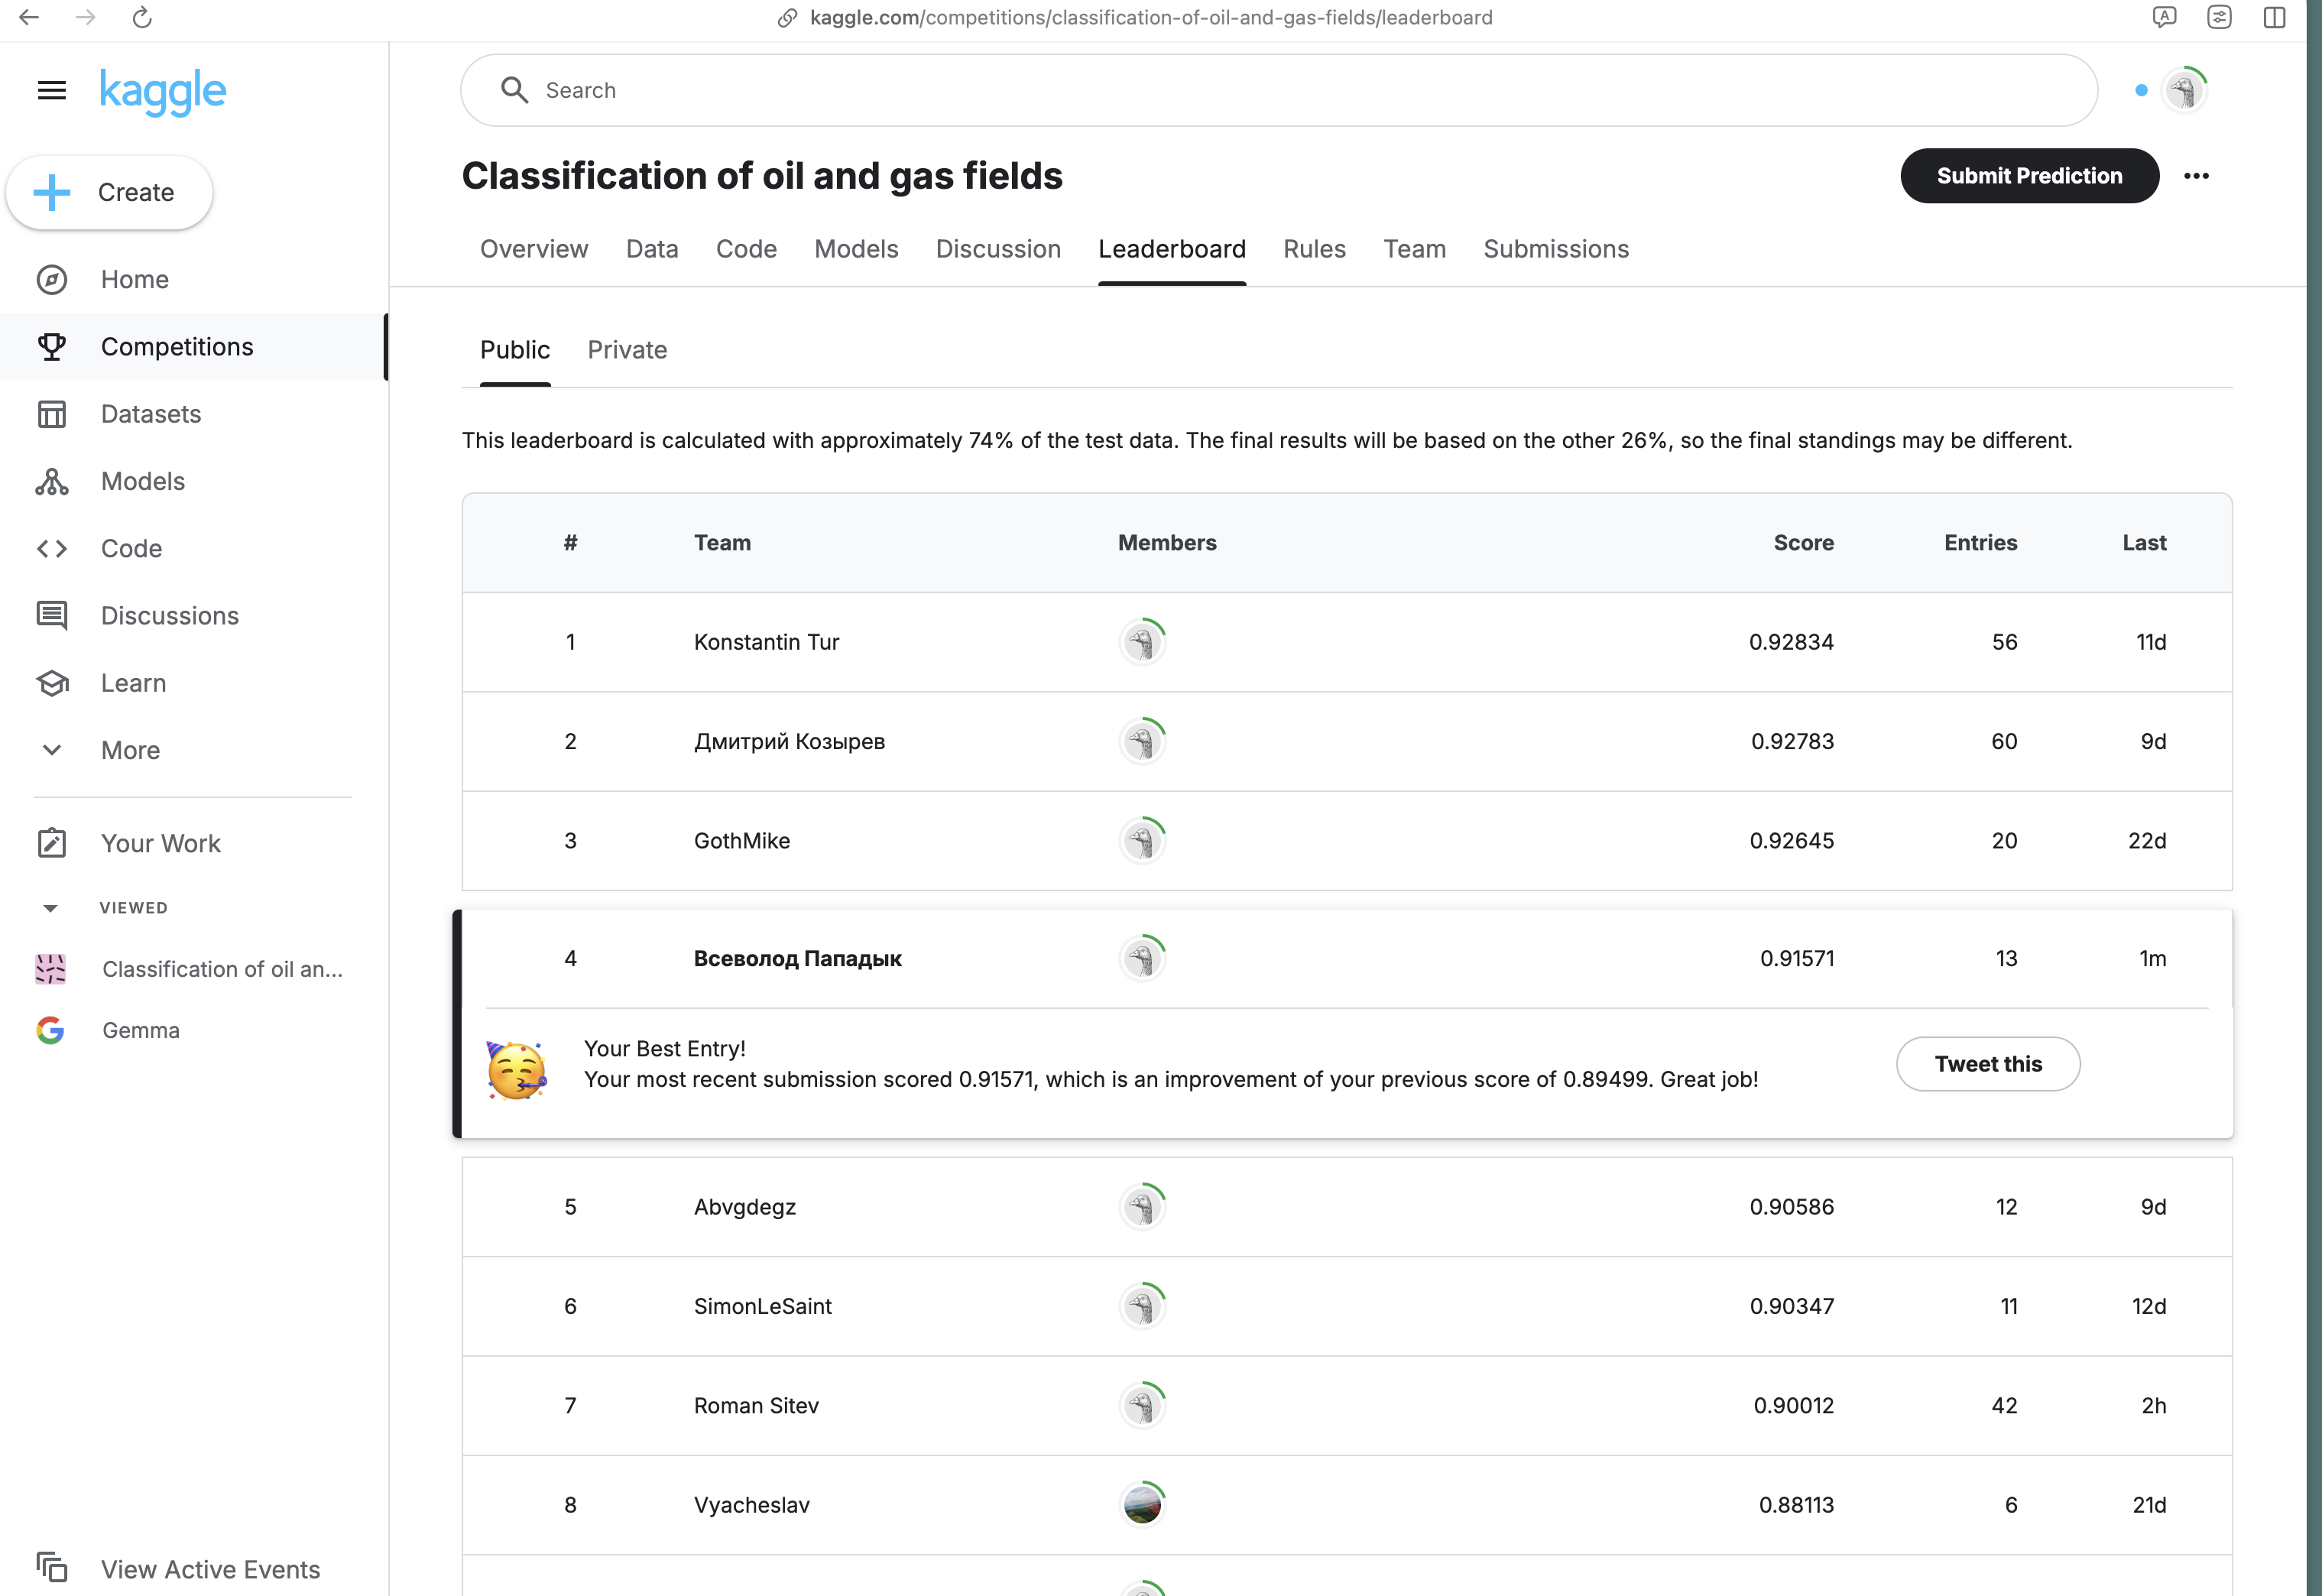